In [1]:
var openDigger = require('../src/open_digger');
var babelId = 24560307;
var webpackId = 3678731;
var ids = [babelId, webpackId];
var idsStr = JSON.stringify(ids);
var year = 2021;

# 2021 供应链研究示例报告

供应链可维护性风险的示例文档：

示例项目为 webpack 和 babel-core。

## 0. SBOM

SBOM 即项目的依赖树信息

## 1.团队健康

团队健康度的两个指标为贡献者数量和核心贡献者数量。

贡献者数量定义为一段时间内有过至少一次代码贡献的开发者数量。

核心贡献者数量定义为一段时间内有过至少三次代码贡献的开发者数量。

由图可得，全域仓库上的贡献者与核心贡献者分布满足典型幂律分布。

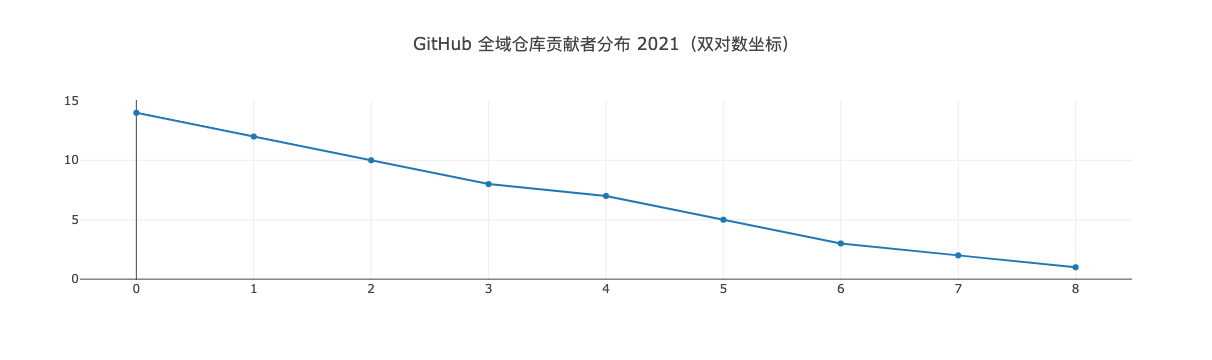

In [2]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count_log, contributor_count_log FROM
    (SELECT repo_id, floor(log(COUNT(DISTINCT issue_author_id))) AS contributor_count_log
    FROM github_log.year${year}
    WHERE type='PullRequestEvent' and action='closed' and pull_merged=1
    GROUP BY repo_id)
GROUP BY contributor_count_log
ORDER BY contributor_count_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.contributor_count_log),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库贡献者分布 ${year}（双对数坐标）`, xasix: { type: 'category' } })
});

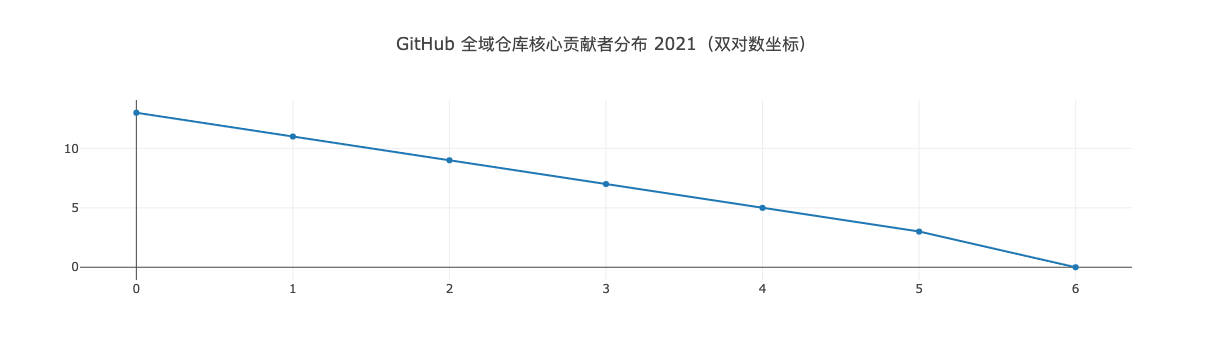

In [3]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count, core_contributor_count_log FROM
    (SELECT repo_id, floor(log(COUNT(actor_id))) AS core_contributor_count_log FROM
        (SELECT repo_id, issue_author_id AS actor_id, COUNT() AS contribution_count
        FROM github_log.year${year}
        WHERE type='PullRequestEvent' and action='closed' and pull_merged=1
        GROUP BY repo_id, actor_id
        HAVING contribution_count >= 3)
    GROUP BY repo_id)
GROUP BY core_contributor_count_log
ORDER BY core_contributor_count_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.core_contributor_count_log),
        y: data.map(d => d.repo_count),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库核心贡献者分布 ${year}（双对数坐标）`, xasix: { type: 'category' } })
});

In [4]:
openDigger.driver.clickhouse.query(`
SELECT any(repo_name) AS name, COUNT(DISTINCT issue_author_id) AS contributor_count
FROM github_log.year${year}
WHERE type='PullRequestEvent' and action='closed' and pull_merged=1 AND repo_id IN ${idsStr}
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has ${row.contributor_count} contributors in ${year}`));
});

The project webpack/webpack has 80 contributors in 2021
The project babel/babel has 102 contributors in 2021


In [5]:
openDigger.driver.clickhouse.query(`
SELECT anyHeavy(name) AS name, COUNT(actor_id) AS core_contributor_count FROM
    (SELECT repo_id, anyHeavy(repo_name) AS name, issue_author_id AS actor_id, COUNT() AS contribution_count
    FROM github_log.year${year}
    WHERE type='PullRequestEvent' and action='closed' and pull_merged=1 AND repo_id IN ${idsStr}
    GROUP BY repo_id, actor_id
    HAVING contribution_count >= 3)
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has ${row.core_contributor_count} core contributors in ${year}`));
});

The project babel/babel has 20 core contributors in 2021
The project webpack/webpack has 11 core contributors in 2021


## 2.社区活跃度

社区活跃度使用 X-lab 定义的社区活跃度计算方式。

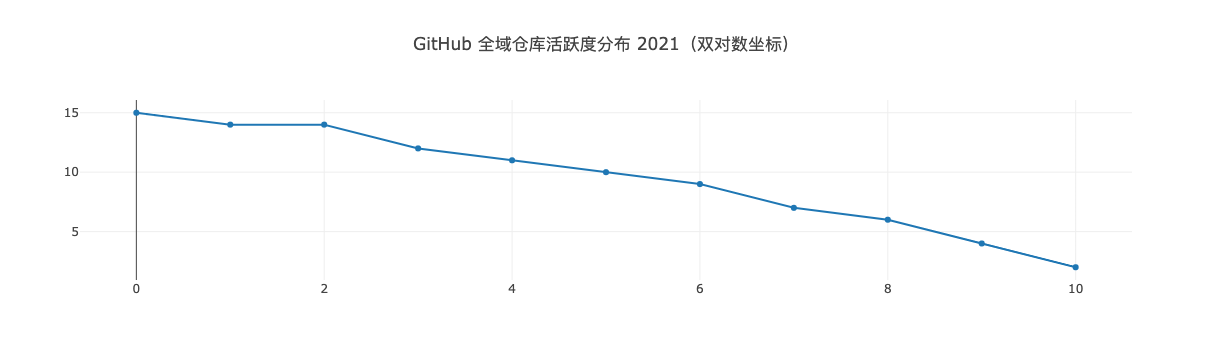

In [6]:
openDigger.driver.clickhouse.query(
`SELECT floor(log(COUNT(repo_id))) AS repo_count_log, activity_log FROM
    (SELECT repo_id, floor(log(SUM(activity))) AS activity_log FROM
        (SELECT repo_id,
            if(type='PullRequestEvent' AND action='closed' AND pull_merged= 1, issue_author_id, actor_id) AS actor_id,
            toMonth(created_at) AS month,
            countIf(type='IssueCommentEvent' AND action='created') AS issue_comment,
            countIf(type='IssuesEvent' AND action='opened') AS open_issue,
            countIf(type='PullRequestEvent' AND action='opened') AS open_pull,
            countIf(type='PullRequestReviewCommentEvent' AND action='created') AS review_comment,
            countIf(type='PullRequestEvent' AND action='closed' AND pull_merged= 1) AS merged_pull,
            sqrt(issue_comment + 2 * open_issue + 3 * open_pull + 4 * review_comment + 2 * merged_pull) AS activity
        FROM github_log.year${year}
        GROUP BY repo_id, actor_id, month
        HAVING activity > 0)
    GROUP BY repo_id)
GROUP BY activity_log
ORDER BY activity_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.activity_log),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库活跃度分布 ${year}（双对数坐标）`, xasix: { type: 'category' } })
});

In [7]:
openDigger.driver.clickhouse.query(
`SELECT repo_id, anyHeavy(name) AS name, round(SUM(activity), 2) AS activity FROM
    (SELECT repo_id,
        anyHeavy(repo_name) AS name,
        if(type='PullRequestEvent' AND action='closed' AND pull_merged= 1, issue_author_id, actor_id) AS actor_id,
        toMonth(created_at) AS month,
        countIf(type='IssueCommentEvent' AND action='created') AS issue_comment,
        countIf(type='IssuesEvent' AND action='opened') AS open_issue,
        countIf(type='PullRequestEvent' AND action='opened') AS open_pull,
        countIf(type='PullRequestReviewCommentEvent' AND action='created') AS review_comment,
        countIf(type='PullRequestEvent' AND action='closed' AND pull_merged= 1) AS merged_pull,
        sqrt(issue_comment + 2 * open_issue + 3 * open_pull + 4 * review_comment + 2 * merged_pull) AS activity
    FROM github_log.year${year}
    WHERE repo_id IN ${idsStr}
    GROUP BY repo_id, actor_id, month)
GROUP BY repo_id
`).then(data => {
   data.forEach(row => console.log(`The project ${row.name} has ${row.activity} activity score in ${year}`));
});

The project babel/babel has 2848.31 activity score in 2021
The project webpack/webpack has 4111.07 activity score in 2021


## 3.MTTU

## 4. Release 频率

Release 频率使用 GitHub 或 Node.js 子生态 ReleaseEvent 事件进行统计。

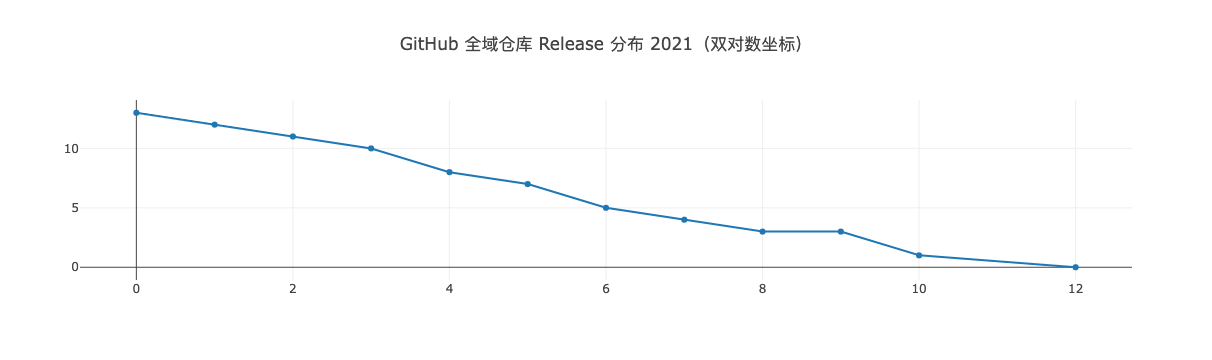

In [8]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count_log, release_count_log FROM
    (SELECT repo_id, floor(log(COUNT())) AS release_count_log
    FROM github_log.year${year}
    WHERE type='ReleaseEvent'
    GROUP BY repo_id)
GROUP BY release_count_log
ORDER BY release_count_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.release_count_log),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库 Release 分布 ${year}（双对数坐标）`, xasix: { type: 'category' } })
});

In [9]:
openDigger.driver.clickhouse.query(`
SELECT repo_id, anyHeavy(repo_name) AS name, COUNT() AS release_count
FROM github_log.year${year}
WHERE type='ReleaseEvent' AND repo_id IN ${idsStr}
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has ${row.release_count} releases in ${year}`));
});

The project webpack/webpack has 97 releases in 2021
The project babel/babel has 51 releases in 2021


## 5. 依赖影响力

依赖影响力使用子生态依赖网络的 PageRank 方法计算。

## 6. 外部依赖度

## 7. Issue 处理能力

年度 Issue 处理能力包含三个指标：

- 未关闭 Issue 占比：即 (全年打开 Issue - 全年关闭 Issue)/全年打开 Issue
- Issue 平均生命周期：即当前打开并关闭的所有 Issue 的平均生命周期
- Issue 首次响应时间：即当前打开并有回复的 Issue 的平均首次响应时间

### 未关闭 Issue 占比

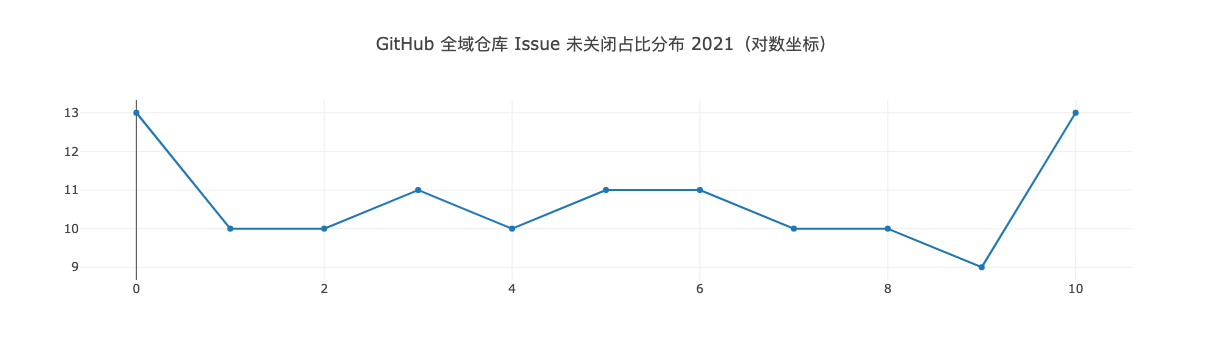

In [10]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count_log, ratio FROM
    (SELECT repo_id, COUNT(open_issue) AS open_issue_count, countIf(close_issue > 0) AS close_issue_count, floor(((open_issue_count - close_issue_count) / open_issue_count) * 10) AS ratio FROM
        (SELECT repo_id, issue_id, countIf(action='opened' OR action='reopened') AS open_issue, countIf(action='closed') AS close_issue
        FROM github_log.year${year}
        WHERE type='IssuesEvent'
        GROUP BY repo_id, issue_id
        HAVING open_issue > 0)
    GROUP BY repo_id)
GROUP BY ratio
ORDER BY ratio
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.ratio),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库 Issue 未关闭占比分布 ${year}（对数坐标）` })
});

In [11]:
openDigger.driver.clickhouse.query(`
SELECT repo_id, anyHeavy(name) AS name, COUNT(open_issue) AS open_issue_count, countIf(close_issue > 0) AS close_issue_count, floor(((open_issue_count - close_issue_count) / open_issue_count) * 100) AS ratio FROM
    (SELECT repo_id, anyHeavy(repo_name) AS name, issue_id, countIf(action='opened' OR action='reopened') AS open_issue, countIf(action='closed') AS close_issue
    FROM github_log.year${year}
    WHERE type='IssuesEvent' AND repo_id IN ${idsStr}
    GROUP BY repo_id, issue_id
    HAVING open_issue > 0)
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has an unclose issue ratio ${row.ratio}% in ${year}`));
});

The project babel/babel has an unclose issue ratio 27% in 2021
The project webpack/webpack has an unclose issue ratio 17% in 2021


### Issue 平均生命周期

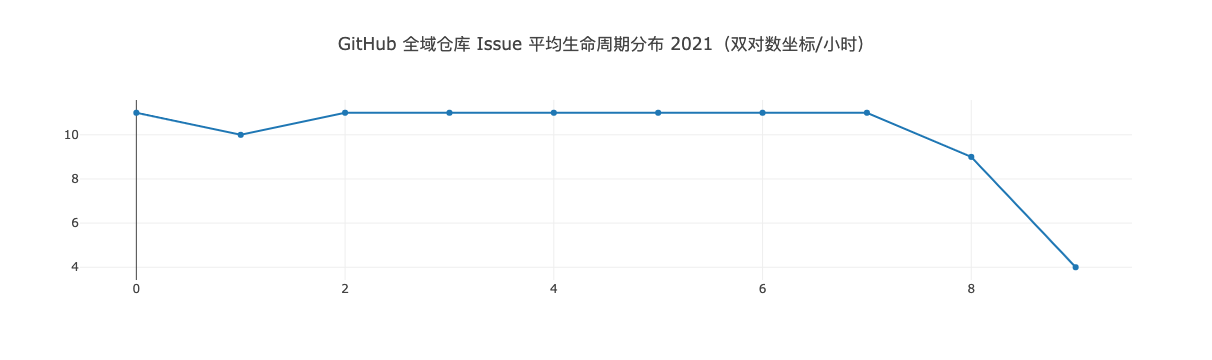

In [13]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count_log, floor(log(issue_lifetime_hour_avg)) AS issue_lifetime_hour_avg_log FROM
    (SELECT repo_id, ceil(avg(dateDiff('hour', issue_created_at, issue_closed_at))) AS issue_lifetime_hour_avg
    FROM github_log.year${year}
    WHERE type='IssuesEvent' AND action='closed' AND toYear(issue_created_at)=${year}
    GROUP BY repo_id
    HAVING issue_lifetime_hour_avg > 0)
GROUP BY issue_lifetime_hour_avg_log
ORDER BY issue_lifetime_hour_avg_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.issue_lifetime_hour_avg_log),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库 Issue 平均生命周期分布 ${year}（双对数坐标/小时）` })
});

In [14]:
openDigger.driver.clickhouse.query(`
SELECT anyHeavy(repo_name) AS name, ceil(avg(dateDiff('hour', issue_created_at, issue_closed_at))) AS issue_lifetime_hour_avg
FROM github_log.year${year}
WHERE type='IssuesEvent' AND action='closed' AND toYear(issue_created_at)=${year} AND repo_id IN ${idsStr}
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has an average issue lifetime of ${row.issue_lifetime_hour_avg} hours in ${year}`));
});

The project webpack/webpack has an average issue lifetime of 453 hours in 2021
The project babel/babel has an average issue lifetime of 340 hours in 2021


### Issue 平均首次响应时间

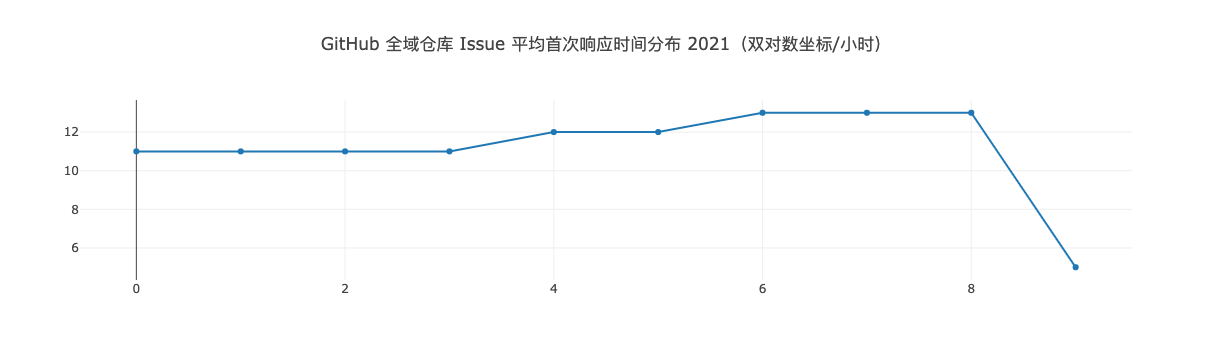

In [15]:
openDigger.driver.clickhouse.query(`
SELECT floor(log(COUNT(repo_id))) AS repo_count_log, floor(log(issue_first_response_hour_avg)) AS issue_first_response_hour_avg_log FROM
    (SELECT repo_id, ceil(avg(issue_first_response_hour)) AS issue_first_response_hour_avg FROM
        (SELECT repo_id, issue_id, ceil(dateDiff('hour', any(issue_created_at), min(created_at))) AS issue_first_response_hour
        FROM github_log.year${year}
        WHERE type='IssueCommentEvent' AND action='created' AND toYear(issue_created_at)=${year}
        GROUP BY repo_id, issue_id
        HAVING issue_first_response_hour > 0)
    GROUP BY repo_id)
GROUP BY issue_first_response_hour_avg_log
ORDER BY issue_first_response_hour_avg_log
`).then(data => {
    openDigger.render.plotly([{
        x: data.map(d => d.issue_first_response_hour_avg_log),
        y: data.map(d => d.repo_count_log),
        name: 'log(仓库数量)'
    }], {title: `GitHub 全域仓库 Issue 平均首次响应时间分布 ${year}（双对数坐标/小时）` })
});

In [16]:
openDigger.driver.clickhouse.query(`
SELECT anyHeavy(name) AS name, ceil(avg(issue_first_response_hour)) AS issue_first_response_hour_avg FROM
    (SELECT repo_id, anyHeavy(repo_name) AS name, issue_id, ceil(dateDiff('hour', any(issue_created_at), min(created_at))) AS issue_first_response_hour
    FROM github_log.year${year}
    WHERE type='IssueCommentEvent' AND action='created' AND toYear(issue_created_at)=${year} AND repo_id IN ${idsStr}
    GROUP BY repo_id, issue_id
    HAVING issue_first_response_hour > 0)
GROUP BY repo_id
`).then(data => {
    data.forEach(row => console.log(`The project ${row.name} has an average issue first response time of ${row.issue_first_response_hour_avg} hours in ${year}`));
});

The project babel/babel has an average issue first response time of 160 hours in 2021
The project webpack/webpack has an average issue first response time of 92 hours in 2021
